In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA


In [3]:
df = pd.read_csv("/content/hyderabad-salaried-employees.csv")
df.head()

,candidateName,companyName,designation,experienceMas,locationCurrentMas,qualificationMas,qualificationMas2,salary,Category
0,Ruchismita Dash,Amdocs,Software Developer,2 Year(s) 1 Month(s),Hyderabad/ Secunderabad,BE/ B.Tech (Engineering),NaN,Rs. 6.71 lacs,HYDERABAD-SALARIED
1,MANISHA DAS,APOLLO HOSPITALS ENTERPRISES LIMITED,SENIOR EXECUTIVE-OPERATIONS,5 Year(s) 9 Month(s),Hyderabad/ Secunderabad,MBA/ PGDM,B.Pharm. (Pharmacy),Rs. 5.0 lacs,HYDERABAD-SALARIED
2,C J GEETHA PRIYA,propertyoneshop.com,System Administrator,4 Year(s) 4 Month(s),Hyderabad/ Secunderabad,B.Com. (Commerce),NaN,Rs. 84.0 lacs,HYDERABAD-SALARIED
3,SRIKANTH,Axis Bank Ltd,NaN,7 Year(s) 11 Month(s),Hyderabad/ Secunderabad,NaN,MBA/ PGDM,Rs. 7.0 lacs,HYDERABAD-SALARIED
4,Madduri Srinivas,CTS,Associate Projects,6 Year(s) 8 Month(s),Hyderabad/ Secunderabad,B.Com. (Commerce),MCA/ PGDCA,Rs. 8.05 lacs,HYDERABAD-SALARIED


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28847 entries, 0 to 28846
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   candidateName       28843 non-null  object
 1   companyName         28806 non-null  object
 2   designation         24217 non-null  object
 3   experienceMas       28847 non-null  object
 4   locationCurrentMas  28847 non-null  object
 5   qualificationMas    23971 non-null  object
 6   qualificationMas2   15449 non-null  object
 7   salary              28847 non-null  object
 8   Category            28847 non-null  object
dtypes: object(9)
memory usage: 2.0+ MB


In [5]:
df.describe()

,candidateName,companyName,designation,experienceMas,locationCurrentMas,qualificationMas,qualificationMas2,salary,Category
count,28843,28806,24217,28847,28847,23971,15449,28847,28847
unique,27288,15153,12636,492,3,51,48,1560,1
top,- -,Currently Unemployed,Currently Unemployed,10 Year(s),Hyderabad/ Secunderabad,BE/ B.Tech (Engineering),MBA/ PGDM,Rs. 6.0 lacs,HYDERABAD-SALARIED
freq,27,804,778,966,28841,8922,5448,1695,28847


In [6]:
df.isna().sum()

candidateName             4
companyName              41
designation            4630
experienceMas             0
locationCurrentMas        0
qualificationMas       4876
qualificationMas2     13398
salary                    0
Category                  0
dtype: int64

In [7]:
df.nunique()

candidateName         27288
companyName           15153
designation           12636
experienceMas           492
locationCurrentMas        3
qualificationMas         51
qualificationMas2        48
salary                 1560
Category                  1
dtype: int64

In [8]:
df.locationCurrentMas.value_counts()

Hyderabad/ Secunderabad    28841
Hyderabad                      3
Hyderabad                      3
Name: locationCurrentMas, dtype: int64

<Axes: >

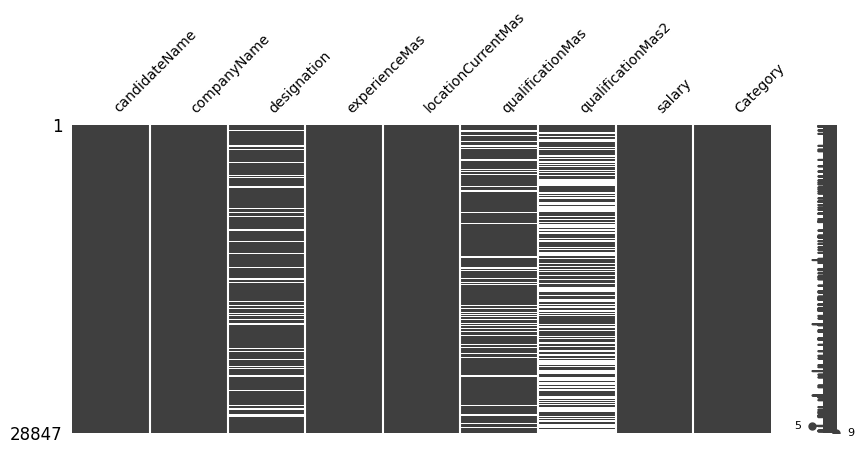

In [9]:
msno.matrix(df, figsize=(10,4), fontsize=10)

In [10]:
df.dropna(axis=0, inplace=True, subset=['companyName', 'designation','candidateName','Category','locationCurrentMas'])

<Axes: >

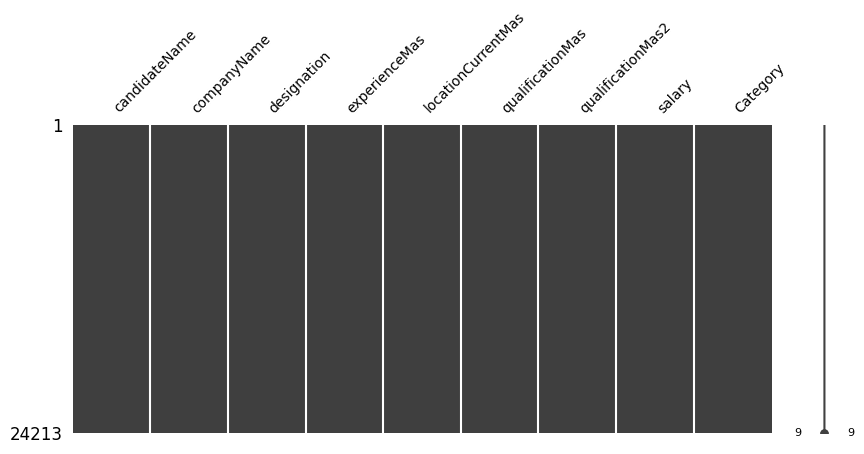

In [11]:
df['qualificationMas'].fillna(value='Missing', inplace=True)
df['qualificationMas2'].fillna(value='Missing', inplace=True)
msno.matrix(df, figsize=(10,4), fontsize=10)

In [12]:
df.drop(columns=['candidateName','Category','locationCurrentMas'], inplace=True)


In [14]:
df['salary'] = df['salary'].astype('str')
df[df.columns[5]] = df[df.columns[5]].apply(lambda x: x.replace('Rs. ','')).apply(lambda x: x.replace(' lacs','')).astype(np.float64)
def process_exp(dataframe,colid):
    df['experienceMas'] = df['experienceMas'].astype('str')
    df['experienceMas'].replace('Fresher','0 Year(s) 0 Month(s)', inplace=True)
    for rowid in range(dataframe.shape[0]):
        element=dataframe.iloc[rowid,colid].split(' ')
        if len(element)==4:
            year,month=(element[0],element[2])
        else:
            year,month=(element[0],0)
        dataframe.iloc[rowid,colid]=(12*float(year))+float(month)
    dataframe.iloc[:,2]=pd.to_numeric(dataframe.experienceMas)
    return dataframe

df=process_exp(dataframe=df, colid=2)
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])
df.head()

,companyName,designation,experienceMas,qualificationMas,qualificationMas2,salary
0,777,9365,300.0,15,43,6.71
1,265,7708,69.0,38,4,5.00
2,12683,10809,52.0,2,43,84.00
4,1928,1430,80.0,2,33,8.05
5,7180,10090,242.0,45,48,16.00


In [15]:
data = pd.DataFrame(normalize(df,axis=0), columns=df.columns)
data.head()

,companyName,designation,experienceMas,qualificationMas,qualificationMas2,salary
0,0.000695,0.008324,0.013295,0.004041,0.007620,0.001818
1,0.000237,0.006851,0.003058,0.010237,0.000709,0.001355
2,0.011345,0.009607,0.002304,0.000539,0.007620,0.022758
3,0.001725,0.001271,0.003545,0.000539,0.005848,0.002181
4,0.006422,0.008968,0.010725,0.012123,0.008506,0.004335


<Axes: >

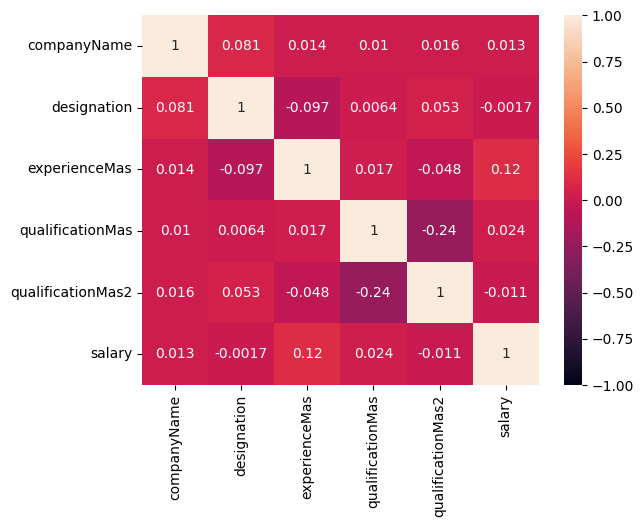

In [16]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)

In [17]:
pca = PCA(n_components=2)
pca.fit(data)
data = pca.transform(data)

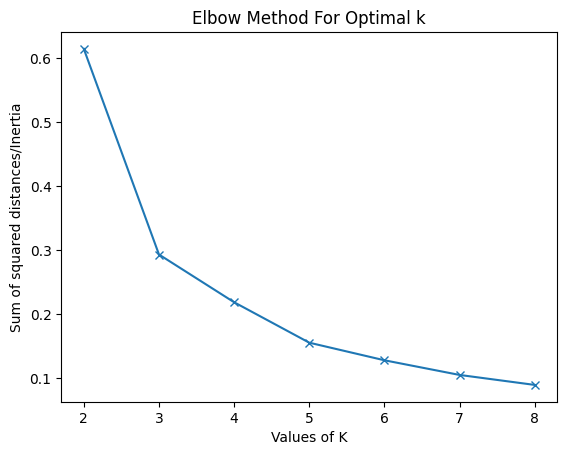

In [18]:
Sum_of_squared_distances = []
K = range(2,9)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'x-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

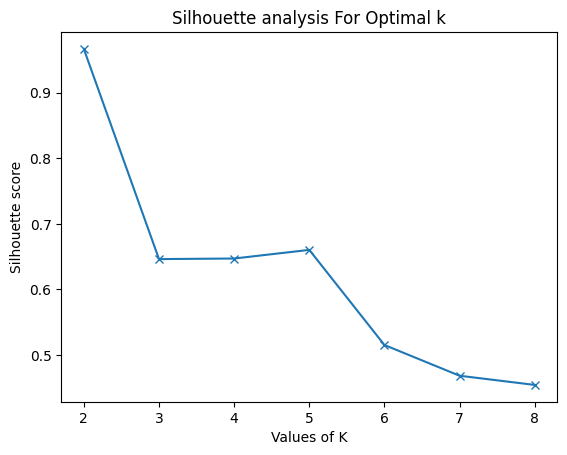

In [19]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(data, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'x-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

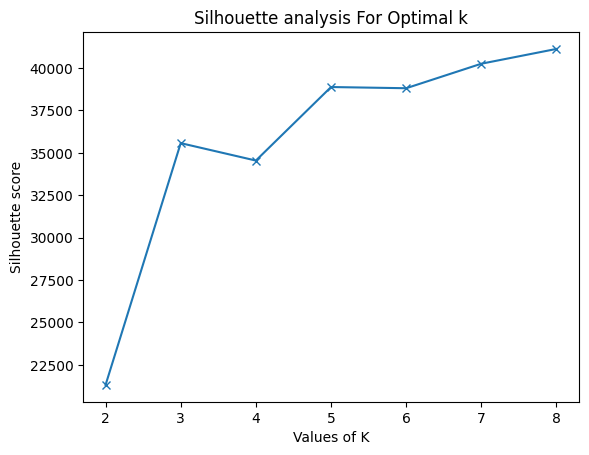

In [20]:
range_n_clusters = range(2,9)
calinski_harabasz_avg = []
for num_clusters in range_n_clusters:
    # inisialisasi kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    # silhouette score
    calinski_harabasz_avg.append(calinski_harabasz_score(data, cluster_labels))

plt.plot(range_n_clusters,calinski_harabasz_avg,'x-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

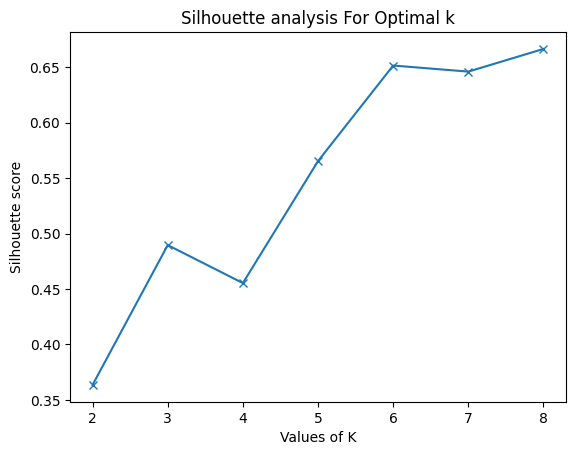

In [21]:
range_n_clusters = range(2,9)
avies_bouldin_avg = []
for num_clusters in range_n_clusters:
    # inisialisaasi kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    # silhouette score
    avies_bouldin_avg.append(davies_bouldin_score(data, cluster_labels))

plt.plot(range_n_clusters,avies_bouldin_avg,'x-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

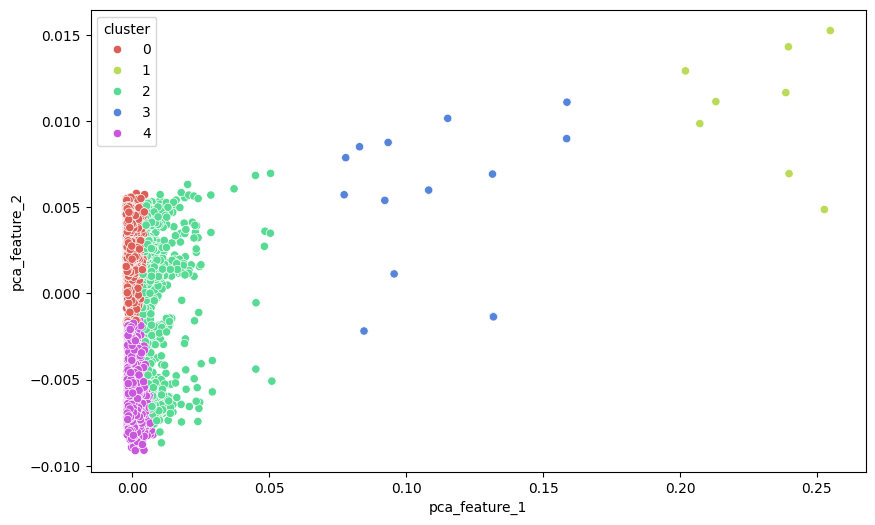

In [22]:
clusters=5
kmeans = KMeans(n_clusters=clusters, init='k-means++')
kmeans.fit(data)
pred = kmeans.predict(data)
data = pd.DataFrame(data, columns = ['pca_feature_1','pca_feature_2'])
data['cluster'] = pred

plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x=data.pca_feature_1, y=data.pca_feature_2, hue='cluster', palette=sns.color_palette("hls",clusters), legend="full")
plt.show()
